# Imports

In [1]:
import numpy as np
import gym
import random
import copy
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt

# Actor critic methods

In [2]:
class Actor(nn.Module):
    def __init__(self, scaling, state_size, hidden_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x)) * scaling

In [3]:
class Critic(nn.Module):
    def __init__(self, state_size, hidden_size, action_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
    
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## TD3

### Defining the agent

In [4]:
class TD3_Agent():
    def __init__(self, scaling, render, buffer_size, batch_size, gamma, tau, sigma,
                state_size, hidden_size, action_size, actor_lr, critic_lr):
        
        self.scaling = scaling
        self.render = render
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.sigma = sigma

        self.state_size = state_size
        self.hidden_size = hidden_size
        self.action_size = action_size
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        
        # Create actor network, 2 critic networks, their target copies, and their optimisers
        self.actor = Actor(scaling, state_size, hidden_size, action_size)
        self.critic = Critic(state_size, hidden_size, action_size)
        self.critic2 = Critic(state_size, hidden_size, action_size)
        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)
        self.target_critic2 = copy.deepcopy(self.critic2)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)
        self.critic_optimizer2 = torch.optim.Adam(self.critic2.parameters(), lr = critic_lr)
        
        self.state_memory = []
        self.next_state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.terminal_memory = []
        self.memory_counter = 0
        
    def train(self):
        state = env.reset()
        ep_reward = 0
        num_step = 0
        terminal = False
        
        while not terminal:
            
            if self.render:
                env.render()
                
            tensor_state = torch.from_numpy(state).float()            
            action = self.actor(tensor_state)
            action = torch.add(action, torch.from_numpy(np.random.normal(0, self.sigma, self.action_size)))
            action = action.detach().numpy()
            next_state, reward, terminal, _ = env.step(action)
            ep_reward += reward

            if self.memory_counter < self.buffer_size: 
                self.state_memory.append(state)
                self.next_state_memory.append(next_state)
                self.action_memory.append(action)
                self.reward_memory.append(reward)
                self.terminal_memory.append(1 - terminal)
            else:     
                index = self.memory_counter % self.buffer_size
                self.state_memory[index] = state
                self.next_state_memory[index] = next_state
                self.action_memory[index] = action
                self.reward_memory[index] = reward
                self.terminal_memory[index] = 1 - terminal
            self.memory_counter += 1    
            
            if self.memory_counter >= self.batch_size: 
                batch = random.sample(range(len(self.state_memory)), self.batch_size) 
                states = []
                next_states = []
                actions = []
                rewards = []
                terminals = []
                
                for item in batch:
                    states.append(self.state_memory[item])
                    next_states.append(self.next_state_memory[item])
                    actions.append(self.action_memory[item])
                    rewards.append(self.reward_memory[item]) 
                    terminals.append(self.terminal_memory[item])
                
                states = np.array(states)
                next_states = np.array(next_states)
                actions = np.array(actions)
                states = torch.tensor(states)
                next_states = torch.tensor(next_states)
                actions = torch.tensor(actions)
                states = states.to(torch.float32) 
                actions = actions.to(torch.float32) 
                next_states = next_states.to(torch.float32) 
                    
                # Calculate policy noise then clip this noise
                # Add this policy noise to the actions that are selected by the actor network when given the next state
                target_actions = self.target_actor(next_states)
                actions_copy = copy.deepcopy(actions)
                noise = actions_copy.data.normal_(0, self.sigma * 2)
                noise = noise.clamp(-self.sigma * 5, self.sigma * 5)      
                target_actions = target_actions + noise
                
                # Calculate the actual next state Q values for each target critic network
                # Choose the smaller of these two next state Q values
                # Use this to calculate the value of actual current state Q values
                a = self.target_critic(next_states, target_actions)
                b = self.target_critic2(next_states, target_actions)
                next_Qtargets = torch.min(a,b) 
                Qtargets = []
                for i in range(self.batch_size):
                    Qtargets.append(rewards[i] + self.gamma * next_Qtargets[i] * terminals[i])
                Qtargets = torch.tensor(Qtargets)
                Qtargets = Qtargets.view(self.batch_size, 1)
                
                # Perform gradient descent on the first critic network             
                Qexpected = self.critic(states, actions)
                critic_loss = nn.MSELoss()(Qexpected, Qtargets)
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()
                
                # Perform gradient descent on the second critic network       
                Qexpected2 = self.critic2(states, actions)
                critic_loss2 = nn.MSELoss()(Qexpected2, Qtargets)
                self.critic_optimizer2.zero_grad()
                critic_loss2.backward()
                self.critic_optimizer2.step()
                
                # Perform gradient ascent on the actor network every 2 steps
                if num_step % 2 == 0:
                    actions_predicted = self.actor(states)
                    actor_loss = -self.critic(states, actions_predicted)
                    actor_loss = torch.mean(actor_loss)
                    self.actor_optimizer.zero_grad()
                    actor_loss.backward()
                    self.actor_optimizer.step()
                
                # Update all target networks
                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_critic.parameters(), self.critic.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau))                    

                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_critic2.parameters(), self.critic2.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau)) 
                
                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_actor.parameters(), self.actor.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau))      
                
            state = next_state
            num_step += 1
            
        if self.render:
            env.close()
            
        return ep_reward
    
    def test(self):
        
        scores = []
        
        for i in range(100):
            state = env.reset()
            terminal = False
            ep_reward = 0

            while not terminal:
                tensor_state = torch.from_numpy(state).float()
                action = self.actor(tensor_state)
                action = action.detach().numpy()
                next_state, reward, terminal, _ = env.step(action)
                ep_reward += reward 
                state = next_state
                
            scores.append(ep_reward)
        
        print('Mean score:', np.mean(scores))
        x = [i for i in range(1, len(scores)+1)]
        plt.plot(x, scores)
        plt.ylabel('Score')
        plt.xlabel('Episodes')
        plt.show()

    def visualise(self):
        for i in range(10):
            state = env.reset()
            terminal = False
            ep_reward = 0

            while not terminal:
                env.render()
                tensor_state = torch.from_numpy(state).float()
                action = self.actor(tensor_state)
                action = action.detach().numpy()
                next_state, reward, terminal, _ = env.step(action)
                ep_reward += reward 
                state = next_state

            print('Episode reward:', ep_reward)
            env.close()

### BipedalWalkerHardcore-v3

#### Training the agent on BipedalWalkerHardcore-v3 from scratch

*************************************************************
Agent 1
Episode: 100 Score: -111.217 	 Mean score over last 100 episodes: -115.611
Episode: 200 Score: -125.680 	 Mean score over last 100 episodes: -118.829
Episode: 300 Score: -156.021 	 Mean score over last 100 episodes: -149.622
Episode: 400 Score: -150.817 	 Mean score over last 100 episodes: -160.567
Episode: 500 Score: -144.484 	 Mean score over last 100 episodes: -151.917
Episode: 600 Score: -106.946 	 Mean score over last 100 episodes: -138.855
Episode: 700 Score: -130.992 	 Mean score over last 100 episodes: -128.975
Episode: 800 Score: -125.331 	 Mean score over last 100 episodes: -116.367
Episode: 900 Score: -102.665 	 Mean score over last 100 episodes: -113.550
Episode: 1000 Score: -173.953 	 Mean score over last 100 episodes: -121.539
Episode: 1100 Score: -188.039 	 Mean score over last 100 episodes: -122.305
Episode: 1200 Score: -161.922 	 Mean score over last 100 episodes: -123.302
Episode: 1300 Score: -158.3

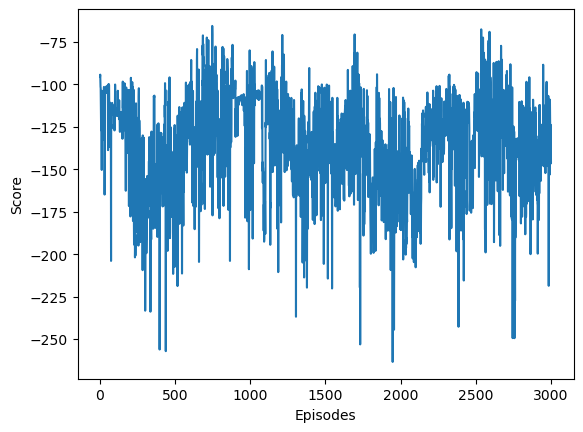

Agent 1 mean score of last 100 episodes during training


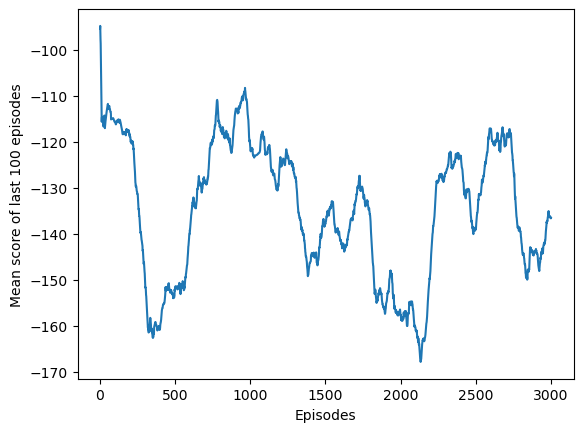

Agent 1 scores during testing
Mean score: -173.4976862109371


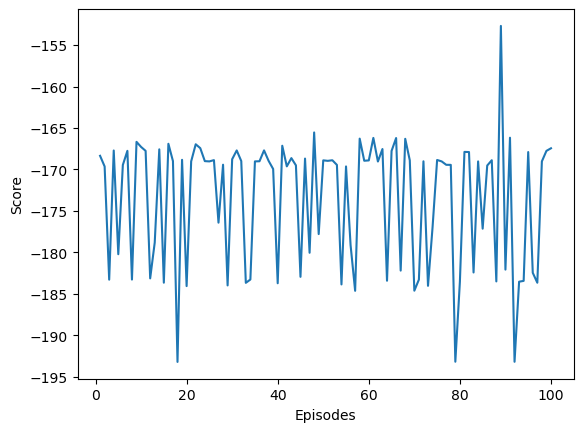

In [5]:
environment = 'BipedalWalkerHardcore-v3'
env = gym.make(environment)

if environment == 'Pendulum-v1':
    scaling = 2
    solved = -100

elif environment =='BipedalWalker-v3' or 'BipedalWalkerHardcore-v3':
    scaling = 1
    solved = 300 

previous = 100
print_every = 100
agents = 1

for i in range(1, agents + 1): 
    print('*************************************************************')
    print('Agent {}'.format(i))

    hardcore_TD3 = TD3_Agent(scaling = scaling, render = False, buffer_size = 500000, batch_size = 64, gamma = 0.99, tau = 0.005, sigma = 0.1,
                state_size = env.observation_space.shape[0], hidden_size = 64, action_size = env.action_space.shape[0], actor_lr = 0.0004, critic_lr = 0.0004)
    agent_scores = [0]
    agent_moving_means = [0]
    episode = 1

    while (agent_moving_means[-1] < solved or episode <= previous) and episode < 3001:

        ep_reward = hardcore_TD3.train()

        if episode == 1:
            agent_scores[0] = ep_reward
            agent_moving_means[0] = ep_reward
        else:
            agent_scores.append(ep_reward)
            agent_moving_means.append(np.mean(agent_scores[-previous:])) 

        if episode % print_every == 0:
            print('Episode: {} Score: {:.3f} \t Mean score over last {} episodes: {:.3f}'.format(episode, ep_reward, previous, agent_moving_means[-1])) 

        episode += 1

    episode -= 1
    print('*********************************')
    print('Agent {} complete \t Mean score of agent: {:.3f}'.format(i, np.mean(agent_scores))) 
    print('{} finished in {} episodes \t Mean score over last {} episodes: {:.3f}'.format(environment, episode, previous, agent_moving_means[-1]))
    print('*********************************')

    x = [i for i in range(1, len(agent_scores) + 1)]
    print('Agent {} scores during training'.format(i))
    plt.plot(x, agent_scores)
    plt.ylabel('Score')
    plt.xlabel('Episodes')              
    plt.show()

    x = [i for i in range(1, len(agent_moving_means) + 1)]
    print('Agent {} mean score of last {} episodes during training'.format(i, previous))
    plt.plot(x, agent_moving_means)
    plt.ylabel('Mean score of last {} episodes'.format(previous))       
    plt.xlabel('Episodes')
    plt.show()
    
    print('Agent {} scores during testing'.format(i))
    hardcore_TD3.test()

In [7]:
hardcore_TD3.visualise()

Episode reward: -183.20564675156794
Episode reward: -169.45406641099675
Episode reward: -167.28786298927164
Episode reward: -168.80706573026168
Episode reward: -168.7042498860604
Episode reward: -167.59869353315375
Episode reward: -184.2906583455329
Episode reward: -179.71511813241798
Episode reward: -168.86037847832296
Episode reward: -167.6877886176082
